## Класифікатори кухонь 1

У цьому уроці ми дослідимо різноманітні класифікатори, щоб *передбачити національну кухню на основі групи інгредієнтів.* Під час цього ми дізнаємося більше про способи використання алгоритмів для задач класифікації.

### [**Тест перед лекцією**](https://gray-sand-07a10f403.1.azurestaticapps.net/quiz/21/)

### **Підготовка**

Цей урок базується на нашому [попередньому уроці](https://github.com/microsoft/ML-For-Beginners/blob/main/4-Classification/1-Introduction/solution/lesson_10-R.ipynb), де ми:

-   Легко ознайомилися з класифікаціями, використовуючи набір даних про всі чудові кухні Азії та Індії 😋.

-   Дослідили деякі [дієслова dplyr](https://dplyr.tidyverse.org/) для підготовки та очищення даних.

-   Створили красиві візуалізації за допомогою ggplot2.

-   Продемонстрували, як працювати з незбалансованими даними, попередньо обробляючи їх за допомогою [recipes](https://recipes.tidymodels.org/articles/Simple_Example.html).

-   Показали, як `prep` і `bake` наш рецепт, щоб переконатися, що він працює належним чином.

#### **Передумови**

Для цього уроку нам знадобляться наступні пакети для очищення, підготовки та візуалізації даних:

-   `tidyverse`: [tidyverse](https://www.tidyverse.org/) — це [колекція пакетів R](https://www.tidyverse.org/packages), створена для того, щоб зробити роботу з даними швидшою, простішою та цікавішою!

-   `tidymodels`: [tidymodels](https://www.tidymodels.org/) — це [фреймворк](https://www.tidymodels.org/packages/), що складається з пакетів для моделювання та машинного навчання.

-   `themis`: [пакет themis](https://themis.tidymodels.org/) надає додаткові кроки для роботи з незбалансованими даними.

-   `nnet`: [пакет nnet](https://cran.r-project.org/web/packages/nnet/nnet.pdf) містить функції для оцінки нейронних мереж прямого поширення з одним прихованим шаром, а також для моделей багатономінальної логістичної регресії.

Ви можете встановити їх так:


`install.packages(c("tidyverse", "tidymodels", "DataExplorer", "here"))`

Альтернативно, наведений нижче скрипт перевіряє, чи встановлені у вас пакети, необхідні для проходження цього модуля, і встановлює їх, якщо вони відсутні.


In [2]:
suppressWarnings(if (!require("pacman"))install.packages("pacman"))

pacman::p_load(tidyverse, tidymodels, themis, here)

Loading required package: pacman



## 1. Розділіть дані на навчальний і тестовий набори.

Почнемо з кількох кроків із нашого попереднього уроку.

### Видаліть найпоширеніші інгредієнти, які створюють плутанину між різними кухнями, використовуючи `dplyr::select()`.

Усі люблять рис, часник і імбир!


In [3]:
# Load the original cuisines data
df <- read_csv(file = "https://raw.githubusercontent.com/microsoft/ML-For-Beginners/main/4-Classification/data/cuisines.csv")

# Drop id column, rice, garlic and ginger from our original data set
df_select <- df %>% 
  select(-c(1, rice, garlic, ginger)) %>%
  # Encode cuisine column as categorical
  mutate(cuisine = factor(cuisine))

# Display new data set
df_select %>% 
  slice_head(n = 5)

# Display distribution of cuisines
df_select %>% 
  count(cuisine) %>% 
  arrange(desc(n))

New names:
* `` -> ...1

Rows: 2448 Columns: 385

── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr   (1): cuisine
dbl (384): ...1, almond, angelica, anise, anise_seed, apple, apple_brandy, a...


ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.



cuisine,almond,angelica,anise,anise_seed,apple,apple_brandy,apricot,armagnac,artemisia,⋯,whiskey,white_bread,white_wine,whole_grain_wheat_flour,wine,wood,yam,yeast,yogurt,zucchini
<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
indian,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
indian,1,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
indian,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
indian,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
indian,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,1,0


cuisine,n
<fct>,<int>
korean,799
indian,598
chinese,442
japanese,320
thai,289


Чудово! Тепер час розділити дані так, щоб 70% даних пішло на тренування, а 30% — на тестування. Ми також застосуємо техніку `стратифікації` при розділенні даних, щоб `зберегти пропорцію кожної кухні` у тренувальному та валідаційному наборах даних.

[rsample](https://rsample.tidymodels.org/), пакет у Tidymodels, забезпечує інфраструктуру для ефективного розділення та повторного вибіркового відбору даних:


In [4]:
# Load the core Tidymodels packages into R session
library(tidymodels)

# Create split specification
set.seed(2056)
cuisines_split <- initial_split(data = df_select,
                                strata = cuisine,
                                prop = 0.7)

# Extract the data in each split
cuisines_train <- training(cuisines_split)
cuisines_test <- testing(cuisines_split)

# Print the number of cases in each split
cat("Training cases: ", nrow(cuisines_train), "\n",
    "Test cases: ", nrow(cuisines_test), sep = "")

# Display the first few rows of the training set
cuisines_train %>% 
  slice_head(n = 5)


# Display distribution of cuisines in the training set
cuisines_train %>% 
  count(cuisine) %>% 
  arrange(desc(n))

Training cases: 1712
Test cases: 736

cuisine,almond,angelica,anise,anise_seed,apple,apple_brandy,apricot,armagnac,artemisia,⋯,whiskey,white_bread,white_wine,whole_grain_wheat_flour,wine,wood,yam,yeast,yogurt,zucchini
<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
chinese,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,1,0,0,0,0,0
chinese,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,1,0,0,0,0,0
chinese,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
chinese,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
chinese,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0


cuisine,n
<fct>,<int>
korean,559
indian,418
chinese,309
japanese,224
thai,202


## 2. Робота з незбалансованими даними

Як ви могли помітити в оригінальному наборі даних, а також у нашому навчальному наборі, існує досить нерівномірний розподіл кількості кухонь. Корейська кухня *майже* втричі перевищує тайську кухню. Незбалансовані дані часто негативно впливають на продуктивність моделі. Багато моделей працюють найкраще, коли кількість спостережень є рівною, і тому їм важко справлятися з незбалансованими даними.

Існує два основних способи роботи з незбалансованими наборами даних:

-   додавання спостережень до меншої категорії: `Over-sampling`, наприклад, використання алгоритму SMOTE, який синтетично генерує нові приклади меншої категорії, використовуючи найближчих сусідів цих випадків.

-   видалення спостережень із більшої категорії: `Under-sampling`

У нашому попередньому уроці ми продемонстрували, як працювати з незбалансованими наборами даних, використовуючи `recipe`. Рецепт можна розглядати як план, який описує, які кроки слід застосувати до набору даних, щоб підготувати його до аналізу. У нашому випадку ми хочемо мати рівномірний розподіл кількості кухонь у нашому `навчальному наборі`. Давайте перейдемо до справи.


In [5]:
# Load themis package for dealing with imbalanced data
library(themis)

# Create a recipe for preprocessing training data
cuisines_recipe <- recipe(cuisine ~ ., data = cuisines_train) %>% 
  step_smote(cuisine)

# Print recipe
cuisines_recipe

Data Recipe

Inputs:

      role #variables
   outcome          1
 predictor        380

Operations:

SMOTE based on cuisine

Ви, звісно, можете підтвердити (використовуючи prep+bake), що рецепт працює так, як ви очікуєте, — усі мітки кухонь мають `559` спостережень.

Оскільки ми будемо використовувати цей рецепт як препроцесор для моделювання, `workflow()` виконає всі підготовчі дії та обробку за нас, тому нам не доведеться вручну оцінювати рецепт.

Тепер ми готові тренувати модель 👩‍💻👨‍💻!

## 3. Вибір класифікатора

<p >
   <img src="../../images/parsnip.jpg"
   width="600"/>
   <figcaption>Ілюстрація від @allison_horst</figcaption>


Тепер нам потрібно вирішити, який алгоритм використовувати для цього завдання 🤔.

У Tidymodels пакет [`parsnip`](https://parsnip.tidymodels.org/index.html) забезпечує уніфікований інтерфейс для роботи з моделями через різні рушії (пакети). Ознайомтеся з документацією parsnip, щоб дослідити [типи моделей та рушії](https://www.tidymodels.org/find/parsnip/#models) і їх відповідні [аргументи моделей](https://www.tidymodels.org/find/parsnip/#model-args). Різноманіття може здатися приголомшливим на перший погляд. Наприклад, наступні методи включають техніки класифікації:

-   Моделі класифікації на основі правил C5.0

-   Гнучкі дискримінантні моделі

-   Лінійні дискримінантні моделі

-   Регуляризовані дискримінантні моделі

-   Моделі логістичної регресії

-   Моделі мультинімної регресії

-   Моделі наївного Байєса

-   Машини опорних векторів

-   Найближчі сусіди

-   Дерева рішень

-   Ансамблеві методи

-   Нейронні мережі

Список можна продовжувати!

### **Який класифікатор обрати?**

Отже, який класифікатор слід вибрати? Часто спроба кількох варіантів і пошук найкращого результату є способом тестування.

> AutoML вирішує цю проблему елегантно, виконуючи ці порівняння в хмарі, що дозволяє вам обрати найкращий алгоритм для ваших даних. Спробуйте це [тут](https://docs.microsoft.com/learn/modules/automate-model-selection-with-azure-automl/?WT.mc_id=academic-77952-leestott)

Також вибір класифікатора залежить від нашої задачі. Наприклад, коли результат можна розділити на `більше ніж два класи`, як у нашому випадку, необхідно використовувати `алгоритм багатокласової класифікації`, а не `бінарну класифікацію.`

### **Кращий підхід**

Кращий спосіб, ніж просто здогадуватися, — це скористатися ідеями з цього завантажуваного [шпаргалки з ML](https://docs.microsoft.com/azure/machine-learning/algorithm-cheat-sheet?WT.mc_id=academic-77952-leestott). Тут ми дізнаємося, що для нашої багатокласової задачі у нас є кілька варіантів:

<p >
   <img src="../../images/cheatsheet.png"
   width="500"/>
   <figcaption>Розділ шпаргалки Microsoft з алгоритмів, що описує варіанти багатокласової класифікації</figcaption>


### **Міркування**

Давайте спробуємо розглянути різні підходи, враховуючи наші обмеження:

-   **Глибокі нейронні мережі занадто важкі**. З огляду на наш чистий, але мінімальний набір даних, а також те, що ми запускаємо навчання локально через ноутбуки, глибокі нейронні мережі є надто громіздкими для цього завдання.

-   **Жодних класифікаторів для двох класів**. Ми не використовуємо класифікатор для двох класів, тому варіант one-vs-all відпадає.

-   **Дерево рішень або логістична регресія можуть підійти**. Дерево рішень може спрацювати, або багатономінальна регресія/багатокласова логістична регресія для багатокласових даних.

-   **Багатокласові Boosted Decision Trees вирішують іншу задачу**. Багатокласове дерево рішень із підсиленням найкраще підходить для непараметричних задач, наприклад, задач, спрямованих на побудову рейтингів, тому для нас це не корисно.

Зазвичай, перед тим як переходити до більш складних моделей машинного навчання, наприклад, ансамблевих методів, варто побудувати найпростішу модель, щоб зрозуміти, що відбувається. Тому для цього уроку ми почнемо з моделі `багатономінальної регресії`.

> Логістична регресія — це метод, який використовується, коли змінна результату є категоріальною (або номінальною). Для бінарної логістичної регресії кількість змінних результату дорівнює двом, тоді як для багатономінальної логістичної регресії кількість змінних результату перевищує дві. Дивіться [Advanced Regression Methods](https://bookdown.org/chua/ber642_advanced_regression/multinomial-logistic-regression.html) для детальнішого ознайомлення.

## 4. Навчання та оцінка моделі багатономінальної логістичної регресії.

У Tidymodels, `parsnip::multinom_reg()` визначає модель, яка використовує лінійні предиктори для прогнозування багатокласових даних за допомогою багатономінального розподілу. Дивіться `?multinom_reg()` для різних способів/двигунів, які можна використовувати для навчання цієї моделі.

Для цього прикладу ми навчимо модель багатономінальної регресії через стандартний двигун [nnet](https://cran.r-project.org/web/packages/nnet/nnet.pdf).

> Я вибрав значення для `penalty` досить випадково. Є кращі способи вибору цього значення, наприклад, використовуючи `resampling` і `tuning` моделі, про які ми поговоримо пізніше.
>
> Дивіться [Tidymodels: Get Started](https://www.tidymodels.org/start/tuning/) у разі, якщо ви хочете дізнатися більше про налаштування гіперпараметрів моделі.


In [6]:
# Create a multinomial regression model specification
mr_spec <- multinom_reg(penalty = 1) %>% 
  set_engine("nnet", MaxNWts = 2086) %>% 
  set_mode("classification")

# Print model specification
mr_spec

Multinomial Regression Model Specification (classification)

Main Arguments:
  penalty = 1

Engine-Specific Arguments:
  MaxNWts = 2086

Computational engine: nnet 


Чудова робота 🥳! Тепер, коли у нас є рецепт і специфікація моделі, нам потрібно знайти спосіб об'єднати їх в один об'єкт, який спочатку буде виконувати попередню обробку даних, потім навчати модель на попередньо оброблених даних, а також дозволить виконувати потенційні дії після обробки. У Tidymodels цей зручний об'єкт називається [`workflow`](https://workflows.tidymodels.org/) і зручно зберігає ваші компоненти моделювання! Це те, що ми назвали б *пайплайнами* у *Python*.

Отже, давайте об'єднаємо все в workflow!📦


In [7]:
# Bundle recipe and model specification
mr_wf <- workflow() %>% 
  add_recipe(cuisines_recipe) %>% 
  add_model(mr_spec)

# Print out workflow
mr_wf

══ Workflow ════════════════════════════════════════════════════════════════════
Preprocessor: Recipe
Model: multinom_reg()

── Preprocessor ────────────────────────────────────────────────────────────────
1 Recipe Step

• step_smote()

── Model ───────────────────────────────────────────────────────────────────────
Multinomial Regression Model Specification (classification)

Main Arguments:
  penalty = 1

Engine-Specific Arguments:
  MaxNWts = 2086

Computational engine: nnet 


Робочі процеси 👌👌! **`workflow()`** можна налаштувати майже так само, як і модель. Отже, час тренувати модель!


In [8]:
# Train a multinomial regression model
mr_fit <- fit(object = mr_wf, data = cuisines_train)

mr_fit

══ Workflow [trained] ══════════════════════════════════════════════════════════
Preprocessor: Recipe
Model: multinom_reg()

── Preprocessor ────────────────────────────────────────────────────────────────
1 Recipe Step

• step_smote()

── Model ───────────────────────────────────────────────────────────────────────
Call:
nnet::multinom(formula = ..y ~ ., data = data, decay = ~1, MaxNWts = ~2086, 
    trace = FALSE)

Coefficients:
         (Intercept)     almond angelica         anise anise_seed       apple
indian    0.19723325  0.2409661        0 -5.004955e-05 -0.1657635 -0.05769734
japanese  0.13961959 -0.6262400        0 -1.169155e-04 -0.4893596 -0.08585717
korean    0.22377347 -0.1833485        0 -5.560395e-05 -0.2489401 -0.15657804
thai     -0.04336577 -0.6106258        0  4.903828e-04 -0.5782866  0.63451105
         apple_brandy     apricot armagnac   artemisia artichoke   asparagus
indian              0  0.37042636        0 -0.09122797         0 -0.27181970
japanese            0

Вивід показує коефіцієнти, які модель навчилася під час тренування.

### Оцінка Навченої Моделі

Час дізнатися, як модель впоралася 📏, оцінивши її на тестовому наборі даних! Почнемо з того, що зробимо прогнози на тестовому наборі.


In [9]:
# Make predictions on the test set
results <- cuisines_test %>% select(cuisine) %>% 
  bind_cols(mr_fit %>% predict(new_data = cuisines_test))

# Print out results
results %>% 
  slice_head(n = 5)

cuisine,.pred_class
<fct>,<fct>
indian,thai
indian,indian
indian,indian
indian,indian
indian,indian


Чудова робота! У Tidymodels оцінювання продуктивності моделі можна виконати за допомогою [yardstick](https://yardstick.tidymodels.org/) - пакета, який використовується для вимірювання ефективності моделей за допомогою метрик продуктивності. Як ми робили на уроці з логістичної регресії, давайте почнемо з обчислення матриці плутанини.


In [10]:
# Confusion matrix for categorical data
conf_mat(data = results, truth = cuisine, estimate = .pred_class)


          Truth
Prediction chinese indian japanese korean thai
  chinese       83      1        8     15   10
  indian         4    163        1      2    6
  japanese      21      5       73     25    1
  korean        15      0       11    191    0
  thai          10     11        3      7   70

Коли маєш справу з кількома класами, зазвичай більш інтуїтивно візуалізувати це у вигляді теплової карти, як ось так:


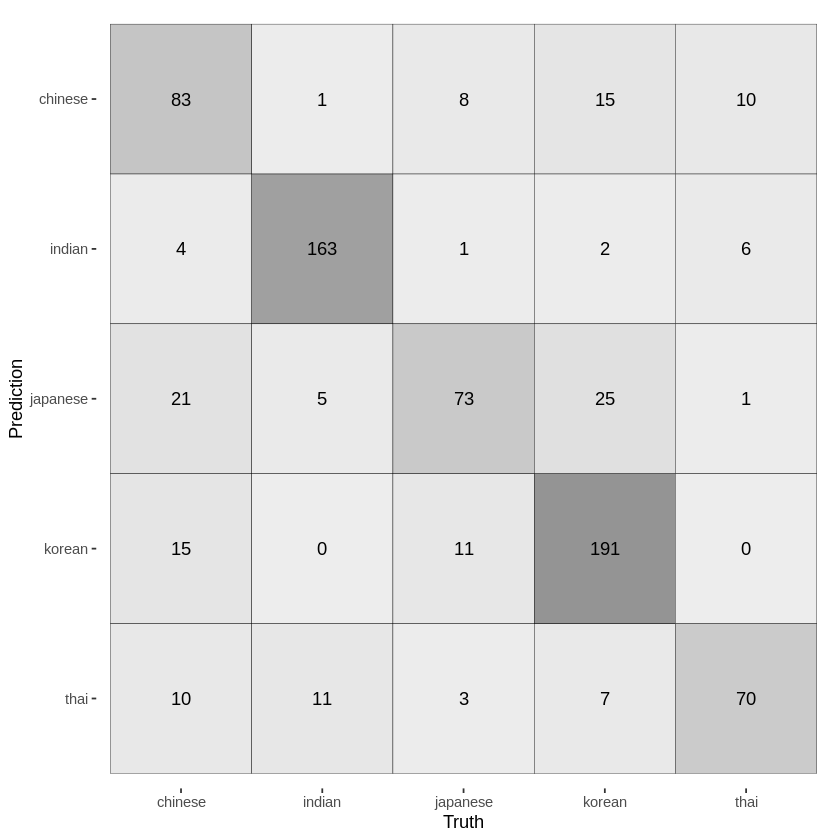

In [11]:
update_geom_defaults(geom = "tile", new = list(color = "black", alpha = 0.7))
# Visualize confusion matrix
results %>% 
  conf_mat(cuisine, .pred_class) %>% 
  autoplot(type = "heatmap")

Темніші квадрати на графіку матриці плутанини вказують на велику кількість випадків, і, сподіваємося, ви можете побачити діагональну лінію темніших квадратів, яка показує випадки, де передбачений і фактичний ярлик збігаються.

Тепер давайте розрахуємо підсумкову статистику для матриці плутанини.


In [12]:
# Summary stats for confusion matrix
conf_mat(data = results, truth = cuisine, estimate = .pred_class) %>% 
summary()

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,multiclass,0.7880435
kap,multiclass,0.7276583
sens,macro,0.7780927
spec,macro,0.9477598
ppv,macro,0.7585583
npv,macro,0.9460080
mcc,multiclass,0.7292724
j_index,macro,0.7258524
bal_accuracy,macro,0.8629262


Якщо ми зосередимося на деяких метриках, таких як точність, чутливість, ppv, то для початку ми не так вже й погано справляємося 🥳!

## 4. Глибше занурення

Давайте поставимо одне тонке запитання: Які критерії використовуються для вибору певного типу кухні як передбаченого результату?

Ну, статистичні алгоритми машинного навчання, такі як логістична регресія, базуються на `ймовірності`; тому те, що фактично передбачає класифікатор, — це розподіл ймовірностей серед набору можливих результатів. Клас із найвищою ймовірністю потім обирається як найбільш ймовірний результат для даних спостережень.

Давайте побачимо це в дії, зробивши як жорсткі передбачення класів, так і ймовірності.


In [13]:
# Make hard class prediction and probabilities
results_prob <- cuisines_test %>%
  select(cuisine) %>% 
  bind_cols(mr_fit %>% predict(new_data = cuisines_test)) %>% 
  bind_cols(mr_fit %>% predict(new_data = cuisines_test, type = "prob"))

# Print out results
results_prob %>% 
  slice_head(n = 5)

cuisine,.pred_class,.pred_chinese,.pred_indian,.pred_japanese,.pred_korean,.pred_thai
<fct>,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
indian,thai,1.551259e-03,0.4587877,5.988039e-04,2.428503e-04,5.388194e-01
indian,indian,2.637133e-05,0.9999488,6.648651e-07,2.259993e-05,1.577948e-06
indian,indian,1.049433e-03,0.9909982,1.060937e-03,1.644947e-05,6.874989e-03
indian,indian,6.237482e-02,0.4763035,9.136702e-02,3.660913e-01,3.863391e-03
indian,indian,1.431745e-02,0.9418551,2.945239e-02,8.721782e-03,5.653283e-03


✅ Чи можете ви пояснити, чому модель впевнена, що перше спостереження є тайським?

## **🚀Виклик**

У цьому уроці ви використали очищені дані для створення моделі машинного навчання, яка може передбачити національну кухню на основі серії інгредієнтів. Приділіть трохи часу, щоб ознайомитися з [багатьма варіантами](https://www.tidymodels.org/find/parsnip/#models), які пропонує Tidymodels для класифікації даних, а також [іншими способами](https://parsnip.tidymodels.org/articles/articles/Examples.html#multinom_reg-models) налаштування багатономіальної регресії.

#### ДЯКУЄМО:

[`Елісон Хорст`](https://twitter.com/allison_horst/) за створення дивовижних ілюстрацій, які роблять R більш привітним і захоплюючим. Більше ілюстрацій можна знайти в її [галереї](https://www.google.com/url?q=https://github.com/allisonhorst/stats-illustrations&sa=D&source=editors&ust=1626380772530000&usg=AOvVaw3zcfyCizFQZpkSLzxiiQEM).

[Кассі Бревіу](https://www.twitter.com/cassieview) та [Джен Лупер](https://www.twitter.com/jenlooper) за створення оригінальної версії цього модуля на Python ♥️

<br>
Хотів би додати кілька жартів, але я не розумію каламбурів про їжу 😅.

<br>

Щасливого навчання,

[Ерік](https://twitter.com/ericntay), Золотий студентський амбасадор Microsoft Learn.



---

**Відмова від відповідальності**:  
Цей документ було перекладено за допомогою сервісу автоматичного перекладу [Co-op Translator](https://github.com/Azure/co-op-translator). Хоча ми прагнемо до точності, зверніть увагу, що автоматичні переклади можуть містити помилки або неточності. Оригінальний документ мовою оригіналу слід вважати авторитетним джерелом. Для критично важливої інформації рекомендується професійний людський переклад. Ми не несемо відповідальності за будь-які непорозуміння або неправильні тлумачення, що виникли внаслідок використання цього перекладу.
